In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, f1_score
import sklearn.metrics
import sys
sys.path.append('../')
import utils as multi

In [2]:
df_train = pd.read_csv('data/titanic/train.csv')
df_test = pd.read_csv('data/titanic/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def preprocess(orig_df: pd.DataFrame):
    df = orig_df.copy()
    embarked_map = {'S': 0, 'C': 1, 'Q': 2}
    drop_columns = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin']
    df['Had Cabin'] = df['Cabin'].map(lambda c: 0 if type(c) != str else 1)
    df['Family size'] = df['SibSp'] + df['Parch']
    df['Embarked'] = df['Embarked'].fillna('S').map(lambda c: embarked_map[c])
    df['Sex'] = df['Sex'].map(lambda c: 0 if c == 'male' else 1)
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

    # Drop all unused columns
    df = df.drop(columns=drop_columns)
    return df
    

In [5]:
def preprocess_drop_na(orig_df: pd.DataFrame):
    df = orig_df.copy()
    embarked_map = {'S': 0, 'C': 1, 'Q': 2}
    drop_columns = ['PassengerId', 'Name','Age', 'SibSp', 'Parch', 'Ticket', 'Cabin']
    df = df.drop(columns=drop_columns)
    df = df.dropna()
    df['Embarked'] = df['Embarked'].map(lambda c: embarked_map[c])
    df['Sex'] = df['Sex'].map(lambda c: 0 if c == 'male' else 1)

    # Drop all unused columns
    
    return df

In [6]:
def make_col_mult(df_o, s):
    df = df_o
    u = df[s].unique()
    for i in u:
        
        df[s  + ' '+ str(i)] = np.where(df[s][:] == i,1,0)
    df = df.drop([s],axis=1)
    return df

In [7]:
df = pd.concat([df_train,df_test])
df_clean = preprocess(df)
df_clean_NNA = preprocess_drop_na(df)

In [8]:
df_clean_NNA.head()

,Survived,Pclass,Sex,Fare,Embarked
0,0.0,3,0,7.2500,0
1,1.0,1,1,71.2833,1
2,1.0,3,1,7.9250,0
3,1.0,1,1,53.1000,0
4,0.0,3,0,8.0500,0


In [9]:
df_clean_mult_sex = make_col_mult(df_clean,'Sex')
df_clean_NNA_mult_sex = make_col_mult(df_clean_NNA,'Sex')

In [10]:
df_train = df_train.drop(['Name','Ticket','Cabin','Age'], axis=1)
df_test = df_test.drop(['Name','Ticket','Cabin','Age'], axis=1)

In [11]:
df_train.loc[df_train['Sex'] == 'male', 'Sex'] = 0
df_train.loc[df_train['Sex'] == 'female', 'Sex'] = 1

df_test.loc[df_test['Sex'] == 'male', 'Sex'] = 0
df_test.loc[df_test['Sex'] == 'female', 'Sex'] = 1

In [12]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,1,0,3,0,1,0,7.2500,S
1,2,1,1,1,1,0,71.2833,C
2,3,1,3,1,0,0,7.9250,S
3,4,1,1,1,1,0,53.1000,S
4,5,0,3,0,0,0,8.0500,S


In [13]:
print(sum(df['Survived'] == 1))

342


In [14]:
print(sum(df['Survived'] == 0))

549


In [15]:
def make_even_split(df):
    num_s = sum(df['Survived'] == 1)
    num_d = sum(df['Survived'] == 0)
    print(num_s)
    print(num_d)
    df_dead = df[df['Survived'] == 0]
    drop_indices = np.random.choice(df_dead.index, (num_d - num_s), replace=False)
    df_subset = df_dead.drop(drop_indices)
    df_fin = pd.concat([df[df['Survived'] == 1],df_dead])
    return df_fin

In [16]:
df_dead = df[df['Survived'] == 0]

In [17]:
drop_indices = np.random.choice(df_dead.index, 209, replace=False)
df_subset = df_dead.drop(drop_indices)

In [18]:
df_fin = make_even_split(df_clean)

342
549


In [19]:
X = df_fin.drop(['Survived'], axis=1)
y = df_fin['Survived']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
clf = LogisticRegression(max_iter=1000)

In [22]:
n_X = (X_train.to_numpy())

In [23]:
clf.fit((X_train), (y_train))

LogisticRegression(max_iter=1000)

In [24]:
clf.score(X_train,y_train)

0.8117977528089888

In [25]:
y_pred = clf.predict(X_test)

In [26]:
clf.score(X_test,y_test)

0.7821229050279329

In [30]:
def pred_df(df_fin):
    X = df_fin.drop(['Survived'], axis=1)
    y = df_fin['Survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000,class_weight='balanced')
    n_X = (X_train.to_numpy())
    clf.fit((X_train), (y_train))
    multi.plot_roc(clf, X_test, y_test, 'Plot of the roc for logistic regression using the titainic dataset')
    print('Training Score')
    print(clf.score(X_train,y_train))
    print('Testing Score')
    print(clf.score(X_test,y_test))
    f1 = multi.calc_f1(clf, X_test, y_test)
    print(f"Weighted F1-score = {f1}")
    pred_y = clf.predict(X_test)
    print(sklearn.metrics.classification_report(y_true=y_test, y_pred=pred_y))

In [31]:
df_clean_e = make_even_split(df_clean)
df_clean_NNA_e = make_even_split(df_clean_NNA)
df_clean_mult_sex_e = make_even_split(df_clean_mult_sex)
df_clean_NNA_mult_sex_e = make_even_split(df_clean_NNA_mult_sex)

342
549
340
549
342
549
340
549


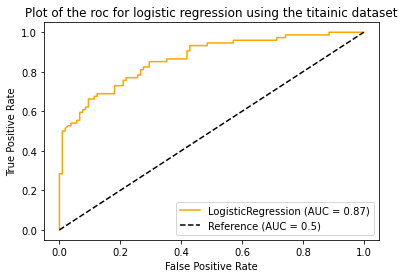

Training Score
0.7907303370786517
Testing Score
0.776536312849162
Weighted F1-score = 0.7776032708664979
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       105
         1.0       0.71      0.77      0.74        74

    accuracy                           0.78       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.78      0.78      0.78       179



In [32]:
pred_df(df_clean_e)

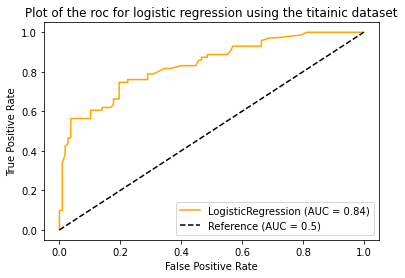

Training Score
0.770745428973277
Testing Score
0.7640449438202247
Weighted F1-score = 0.7640449438202247
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       107
         1.0       0.70      0.70      0.70        71

    accuracy                           0.76       178
   macro avg       0.75      0.75      0.75       178
weighted avg       0.76      0.76      0.76       178



In [33]:
pred_df(df_clean_NNA_e)

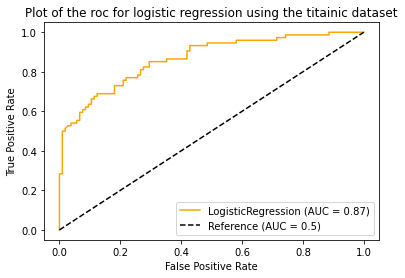

Training Score
0.7907303370786517
Testing Score
0.776536312849162
Weighted F1-score = 0.7776032708664979
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       105
         1.0       0.71      0.77      0.74        74

    accuracy                           0.78       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.78      0.78      0.78       179



In [34]:
pred_df(df_clean_mult_sex_e)

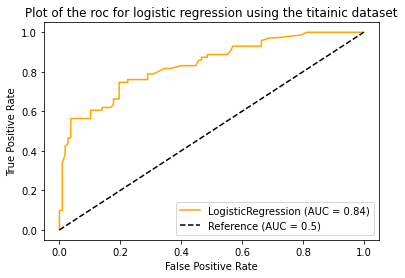

Training Score
0.770745428973277
Testing Score
0.7640449438202247
Weighted F1-score = 0.7640449438202247
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       107
         1.0       0.70      0.70      0.70        71

    accuracy                           0.76       178
   macro avg       0.75      0.75      0.75       178
weighted avg       0.76      0.76      0.76       178



In [35]:
pred_df(df_clean_NNA_mult_sex_e)